In [1]:
from astropy.io import fits as pf
from scipy.ndimage import map_coordinates
from scipy import interpolate as ip

import numpy as np
import matplotlib.pyplot as plt

In [2]:
spec = pf.open('../../galaxy_spectra/lris-longslit-red-1120/spec2d_r201121_0030-J0040+2555_LRISr_2020Nov21T045325.037.fits')

In [3]:
# loading 2d wave image and science image
data_org = spec[12].data
wavim_org = spec[19].data
print(data_org.shape)
print(wavim_org.shape)

(4096, 2048)
(4096, 2048)


### For this 2d spectra dispersion axis is the 'y' axis. That means each row in 2d wave image should have sames values of wavelength. And wavelength will vary along the columns. The following is a plot of how wavelength is changing in a typical column.

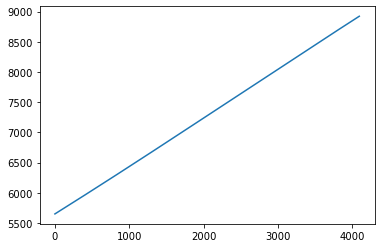

In [4]:
spec_pix = np.arange(4096)
plt.plot(spec_pix, wavim_org[:, 200])

### In the above plot we can a straight line which means dispersion is constant along the columns. We can check dispersion for each column and plot it. 

### Here, first we have trimmed the 2d wave image as we are only interested in that part of the spectra. Then we have fit a first order ploynomial or straight line to each column of that trimmed 2d wave image. Next we have plotted the slope vs column number (spatial pixel) as the slope reflects the dispersion in that column.

In [5]:
data = data_org[:, 40:171]
wavim = wavim_org[:, 40:171]
print(data.shape)
print(wavim.shape)

(4096, 131)
(4096, 131)


(0.803, 0.804)

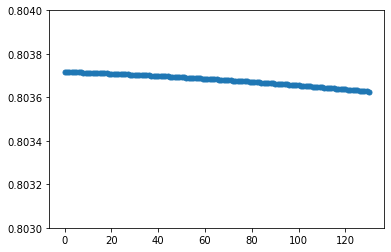

In [6]:
disp = np.polyfit(spec_pix, wavim , deg=1)[0]

plt.plot(np.arange(wavim.shape[1]), disp, '.', markersize=10)
plt.ylim(0.803, 0.804)

### We can say dispersion is constant along the columns. And that dispersion is 0.8 Ang.

### Next we check how wavelength values are changing in each row which is expected to be constant. The following is a plot of the difference between the maximum and minimum values in each row of the trimmed wave image.

Text(0, 0.5, 'Angstrom')

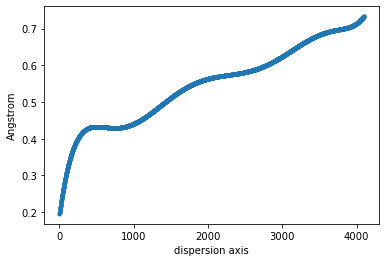

In [7]:
diff = []
for i in range(wavim.shape[0]):
    diff.append(np.max(wavim[i:i+1, :]) - np.min(wavim[i:i+1, :]))

plt.plot(spec_pix, diff , '.')
plt.xlabel('dispersion axis')
plt.ylabel('Angstrom')

### It is clear that the wavelength values are not constant in each row. Now we can check how the wave values are changing in each row. Is there a trend or is it arbitary ? So we are going to plot the wavelengths in first , middle and last row. The first wavelength value is around 5648 Ang, the middle around 7275 Ang and the last is around 8924 Ang.

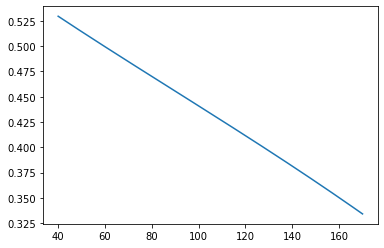

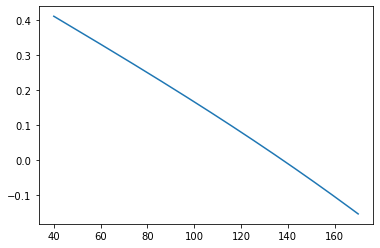

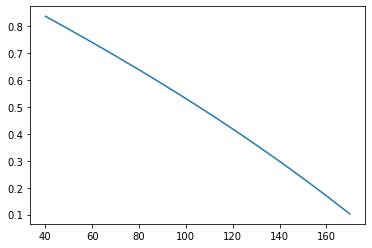

In [8]:
plt.plot(np.arange(40, 171), wavim[0]- 5648.0)
plt.figure()
plt.plot(np.arange(40, 171), wavim[2047]- 7275.0)
plt.figure()
plt.plot(np.arange(40, 171), wavim[-1] - 8924.0)

### So we can see they are all tilted in the same direction. In each row the wavelength values are decreasing in the direction of higher spatial pixel values.

### We could rectify for this tilt. Here is how we are going to do that. This 2d wave image has an underlying coordinate system in terms of pixel numbers. We can assume that the wavelengths in the first column of each row in our trimmed wave image are the intended values for each row. Then we can do some inverse interpolation and  calculate what sould be the coordinate value for each wavelength in the row if they were equal to the value of the intened one or the wavelength value of the first column in that row. 

### We have calculated those coordinate values in terms of pixel numbers and used the 'map_coordiante' function from scipy to evalulate the wavelength values for those coordinates. If we provide the 'map_coordiante' function an input array and a coordinate array then this function will evaluate the values in the place of those given coordinates by interpolating the elements in the input array. We found that our calculated coordiantes map out an array where each row has constant wavelength which is equal to the wavelength value of the first column in that row as expected.

In [9]:
#wav_grid = abs(wavim - 5648.45) / 0.8
#wav_grid = np.insert(wav_grid, 0, np.ones(160), axis=0)
#print(wav_grid)

### First an example of how 'map_coordinate' function perform interpolations for 2d. Here 'a' is the input vector, second input in the 'map_coordinate' function is the coordinate array and we want to do spline interpolation of order one. There are two arrays in the coordinate array. First one is for 'x' coordinates and the second one for 'y' coordinates.
### Now if one provides coordinate (0, 0) as input then the output is of course '0'. 

In [9]:
a = np.arange(12.).reshape((4, 3))
print(a)
map_coordinates(a, [[0, 2], [0, 1]], order=1)

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]]


array([0., 7.])

### Now if the input coordinate is (0.3, 0) then the ouput is '0.9'. That means if one fixes the column coordinate and only increases the row coordinate then the interpolation happens between the two rows of the fixed column. In this case first and second row of the first column.

In [10]:
map_coordinates(a, [[0.3, 2.3], [0, 1]], order=1)

array([0.9, 7.9])

### Next if the input coordinate is (0, 0.3) then the ouput is '0.3'. That means if one fixes the row coordinate and only increases the column coordinate then the interpolation happens between the two columns of the fixed row. In this case first and second column of the first row.

In [11]:
map_coordinates(a, [[0, 2], [0.3, 1.3]], order=1)

array([0.3, 7.3])

### Then one would guess if the input coordinate is (0.3, 0.3) then the ouput is '1.2'. That means if one increases both the row column coordinate then the interpolation happens diagonally, between the (i,j) and (i+1, j+1) elements. In this case (0,0) and (1,1) elements.

In [12]:
map_coordinates(a, [[0.3, 2.3], [0.3, 1.3]], order=1)

array([1.2, 8.2])

### So we see if we only change the 'x' coordinates then the interpolation happens between rows. That means now we can perform interpolation between rows (wavelengths) and calculate the coordinate value for a particular wavelength. Then if we provide these calculated coordinates as the 'x' array of the input coordinate and spatial pixel numbers as the 'y' array and our trimmed wave image as the input to be interpolated, then the 'map_coordinate' function should give us a wave image where each row has that particular wavelength for which we have calculated the 'x' coordinates. 

### Here is an example where we are interpolating between two wavelengths with original coordinate value (0,0) and (1,0). Then we are calculating new coordiante value for a particular wavelength. 

In [13]:
x=np.array([0, 1])     #, 2, 3, 4, 5, 6, 7, 8])
y=np.array([wavim[0][0], wavim[1][0]])      #, 4, 5, 6, 7, 8, 9, 10])
 
f = ip.interp1d(y, x, kind='slinear', fill_value='extrapolate')

print('calculated x coordinate = %f' %f(5648.6))  # some wavelength value in between 

calculated x coordinate = 0.091139


### Now we are going to calculate all 'x' coordinates by interpolating rows in the 2d wave image so that using 'map_coordinate' function and these new coordinates we can map out a new wave image where all the rows have constant wavelengths.

In [14]:
new_co = np.zeros(wavim.shape)
 
for i in range(wavim.shape[0]-1):
    x = np.array([i, i+1])
    for j in range(wavim.shape[1]):
        y = np.array([wavim[i][j], wavim[i+1][j]])
        #print(y)
        f = ip.interp1d(y, x, kind='slinear')    #, fill_value='extrapolate')
        new_co[i][j] = f(wavim[i][0])

### Now we are going to map out the new wave image from the original wave image.

In [15]:
spatial_grid = np.arange(wavim.shape[1])
new_wavim = np.zeros(wavim.shape)

for i in range(wavim.shape[0]-1):
    new_wavim[i] = map_coordinates(wavim,  np.array([new_co[i], spatial_grid]), order=1) #, mode='mirror')

### Now let's check how the wave values are changing in each row. We are going to plot the wavelengths in first , middle and last row as before. They should be constant.

(8923.944179876567, 8924.136006486928)

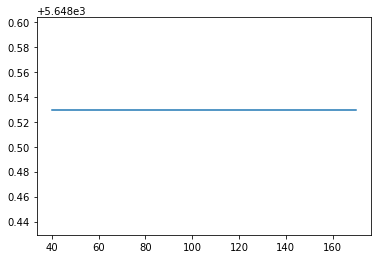

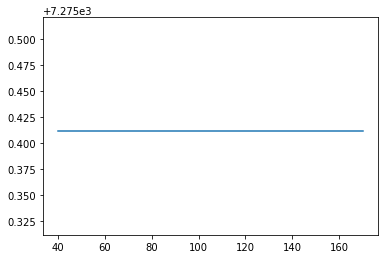

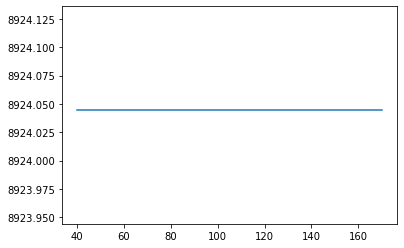

In [16]:
plt.plot(np.arange(40, 171), new_wavim[0]) #- wavim[0][0])
plt.ylim(wavim[0][0]-0.1, wavim[1][0]-.7)
plt.figure()
plt.plot(np.arange(40, 171), new_wavim[2047]) #- wavim[0][0])
plt.ylim(wavim[2047][0]-0.1, wavim[2048][0]-.7)
plt.figure()
plt.plot(np.arange(40, 171), new_wavim[-2])# - wavim[-1][0])
plt.ylim(wavim[-2][0]-0.1, wavim[-1][0]-.7)

### Now check the differenec between the maximum and minimum values in all the rows.

Text(0, 0.5, 'Angstrom')

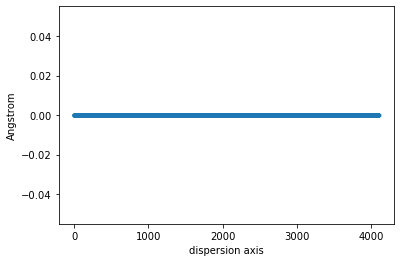

In [17]:
diff1 = []
 
for i in range(wavim.shape[0]):
    diff1.append(round(np.max(new_wavim[i:i+1, : ]) - np.min(new_wavim[i:i+1, : ]), 4))

plt.plot(spec_pix, diff1 , '.')
plt.xlabel('dispersion axis')
plt.ylabel('Angstrom')

### Now check the dispersion in  all the columns.

(0.8008, 0.8011)

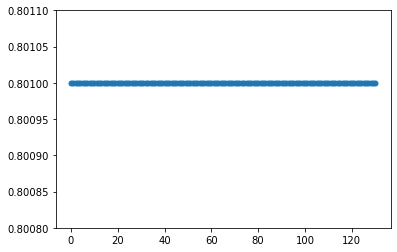

In [18]:
disp1 = np.around(np.polyfit(spec_pix, new_wavim , deg=1)[0], 3)

plt.plot(np.arange(wavim.shape[1]), disp1, '.', markersize=10)
plt.ylim(0.8008, 0.8011)

In [ ]:
spatial_grid

In [ ]:
print(new_co[0])

In [ ]:
print(new_co[0][108])
print(wavim[0][108])
print(wavim[1][108])

In [ ]:
a1 = t[0]
a2 =np.arange(131)
#a = np.array([t[0].tolist(), spatial_grid.tolist()])
a = np.array([a1, a2])
#np.array([a[0].tolist(), a[1].tolist()]).shape
a.shape
t = np.zeros(wavim.shape)
np.array([t[0], t[8]]).shape
#a2

In [ ]:
print(np.max(new_wavim)-np.min(new_wavim))
print(np.max(wavim[0])-np.min(wavim[0]))

In [ ]:
np.zeros(wavim.shape).shape

In [ ]:
x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
y=np.array([0, 3, 4, 5, 6, 7, 8, 9, 10])
f = ip.interp1d(y,x, kind='cubic')
f(3)

In [ ]:
disp[0]

In [25]:
new_wavim[0:-1, :].shape

(4095, 131)